In [2]:
import algorithms.train as train
import algorithms.utils as utils
import algorithms.models as models
from enviroments_cont import env_hubs_cont_1
from algorithms.agents import reinforce, trpo, ppo
import matplotlib.pyplot as plt
import numpy as np
import torch
import gym
import time
import pickle

In [3]:
name_exp = "Exp28"
Red_name = "hub-cont-1"
Demand_Model = "MNLsimple" #Puede ser EXP/MNL
Qfun_model = "NN-PG11" #Puede ser LR/NN

In [4]:
env = env_hubs_cont_1(T = 100)
M = 6
F = 2

#Dimensiónes del espacio de estados
dims_state = list(env.C + 1)
dims_state.append(env.T+1)

#Dimensiones del espacio de acciones
dims_action = [M, F]


In [5]:
actor = models.PolicyNetwork(
    num_inputs=len(dims_state), 
    num_hiddens=[128, 128], 
    num_outputs= [M], 
    init_bias = torch.tensor(env.c_j),
    model="gaussian"
).double()

critc = models.ValueNetwork(
    num_inputs=len(dims_state), 
    num_hiddens=[128, 128], 
    num_outputs=1, 
).double()

Trainer = train.Trainer("sgd", "sgd")

In [6]:
ppo_agent = ppo.PPOGaussianNN(actor, critc,gamma=1, tau=1, lr_actor=1e-4, epochs=100,eps_clip=0.2, device=torch.device("cpu"))

In [7]:
s, _ = env.reset()
s = torch.as_tensor(s).double()
print(s)
a = ppo_agent.policy.actor(s)
print(a)
print(env.c_j)

tensor([20., 17., 39., 70.], dtype=torch.float64)
(tensor([ 499.9960,  700.0042,  499.9838,  799.9554,  749.9921, 1099.9790],
       dtype=torch.float64, grad_fn=<ViewBackward0>), tensor([3.9687, 4.3357, 5.0000, 3.7140, 4.5436, 4.9422], dtype=torch.float64,
       grad_fn=<ClampBackward1>))
[ 500  700  500  800  750 1100]


In [8]:
import time

R_exp = []
time_exp = []
qfun_exp = []
pg_model = []

PG_MODEL = "PPO"
epochs=60000
max_steps=2000
update_freq=3000
initial_offset=0

if PG_MODEL == "PPO":
    start_time = time.time()
    agent, totals,_,mu_list,sigma_list = Trainer.train(env, ppo_agent, epochs, max_steps, update_freq, initial_offset)
    end_time = time.time()
    execution_time = end_time - start_time

pg_model.append(PG_MODEL)
R_exp.append(totals)
time_exp.append(execution_time)
qfun_exp.append(agent)

/home/jorejuela/Code/venv/lib/python3.8/site-packages/torch/autograd/__init__.py:266: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


KeyboardInterrupt: 

/tmp/ipykernel_3374093/1526695116.py:24: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("results/"+ name_exp + "/Mu" + Demand_Model + "_" + Qfun_model +"_" + Red_name +".png")
/home/jorejuela/Code/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


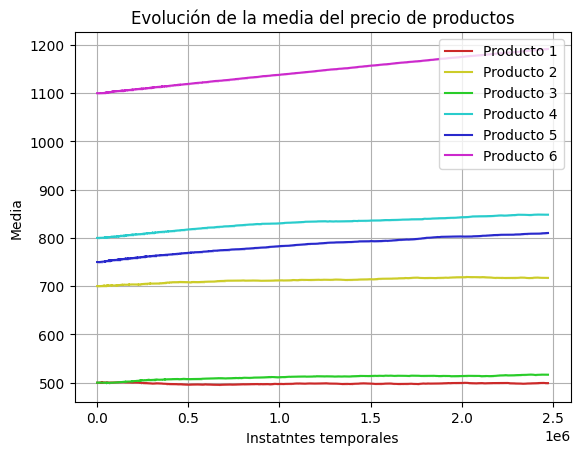

In [ ]:
from algorithms.utils import generate_random_colors
colors = generate_random_colors(6)

len_filter = 100

for i in range(env.J):
    Rs = np.array(mu_list)[:,i]
    mean = np.array([np.mean(Rs[i:i+len_filter]) for i in range(len(Rs) - 10)])
    std = np.array([np.std(Rs[i:i+len_filter]) for i in range(len(Rs) - 10)])
    time = np.arange(mean.size)
    plt.plot(mean,color=colors[i],label=f'Producto {i+1}')
    #plt.plot(Rsim, color = 'r')
    plt.fill_between(time, mean - std, mean + std, color=colors[i], alpha=0.2)


# Añadir título y etiquetas
plt.title('Evolución de la media del precio de productos')
plt.xlabel('Instatntes temporales')
plt.ylabel('Media')
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.savefig("results/"+ name_exp + "/Mu" + Demand_Model + "_" + Qfun_model +"_" + Red_name +".png")
    


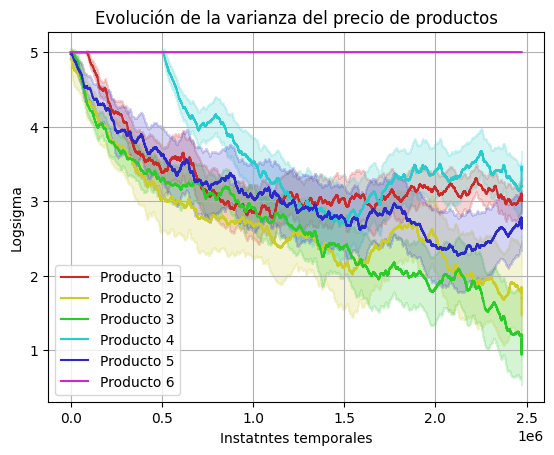

In [ ]:
from algorithms.utils import generate_random_colors
colors = generate_random_colors(6)

Rs = np.array(R_exp[0]).ravel()
len_filter = 10000

for i in range(env.J):
    Rs = np.array(sigma_list)[:,i]
    mean = np.array([np.mean(Rs[i:i+len_filter]) for i in range(len(Rs) - 10)])
    std = np.array([np.std(Rs[i:i+len_filter]) for i in range(len(Rs) - 10)])
    time = np.arange(mean.size)
    plt.plot(mean,color=colors[i],label=f'Producto {i+1}')
    #plt.plot(Rsim, color = 'r')
    plt.fill_between(time, mean - std, mean + std, color=colors[i], alpha=0.2)


# Añadir título y etiquetas
plt.title('Evolución de la varianza del precio de productos')
plt.xlabel('Instatntes temporales')
plt.ylabel('Logsigma')
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.savefig("results/"+ name_exp + "/Sigma" + Demand_Model + "_" + Qfun_model +"_" + Red_name +".png")

In [ ]:
import os
# Asegurarse de que el directorio exista, si no existe, créalo
directory = "results/" + name_exp
if not os.path.exists(directory):
    os.makedirs(directory)

exp = {}
exp["R_exp"] = R_exp
exp["Time_exp"] = time_exp
exp["qfun_exp"] = qfun_exp
exp["PG_model"] = pg_model
#exp["mu_list"] = mu_list
#exp["sigma_list"] = sigma_list

with open("results/"+ name_exp +"/" + Demand_Model + "_" + Qfun_model +"_" + Red_name +".pickle", 'wb') as f:
    pickle.dump(exp, f)

In [9]:
with open("results/"+ name_exp +"/" + Demand_Model + "_" + Qfun_model +"_" + Red_name +".pickle", 'rb') as f:
    exp = pickle.load(f)

R_exp = exp["R_exp"]
time_exp = exp["Time_exp"]
qfun_exp = exp["qfun_exp"] 

FileNotFoundError: [Errno 2] No such file or directory: 'results/Exp28/MNLsimple_NN-PG7_hub-cont-1.pickle'

In [4]:
time_exp[0]/3600

1.5974147976107067

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


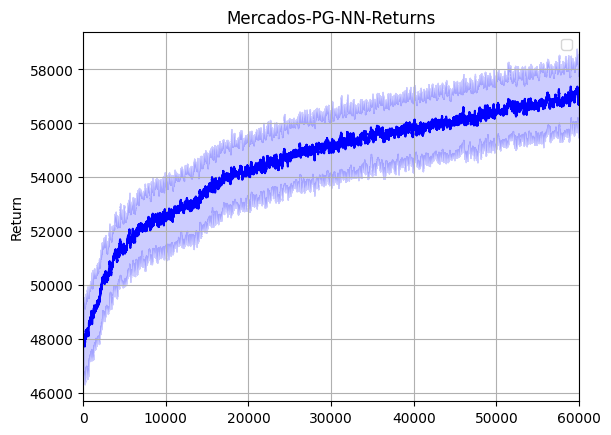

In [11]:
from algorithms.utils import generate_random_colors

colors = generate_random_colors(1)

Rs = np.array(R_exp[0]).ravel()
len_filter = 100
mean = np.array([np.mean(Rs[i:i+len_filter]) for i in range(len(Rs) - 10)])
std = np.array([np.std(Rs[i:i+len_filter]) for i in range(len(Rs) - 10)])
time = np.arange(mean.size)
plt.plot(mean,color='b')
#plt.plot(Rsim, color = 'r')
plt.fill_between(time, mean - std, mean + std, color='b', alpha=0.2)

plt.xlim(0, len(Rs))
plt.grid()
plt.ylabel("Return")
plt.legend()
plt.title("Mercados-PG-NN-Returns")
    
plt.savefig("results/"+ name_exp + "/Returns_" + Demand_Model + "_" + Qfun_model +"_" + Red_name +".png")

In [5]:
print(time_exp)

[1660.3515419960022]


In [6]:
env = env_hubs3()
num_sim = 2000
max_steps = env.T

Rs = []
R_t= []
S_sf = []
Num_politicas = 4

for p in range(Num_politicas):
    rs = []
    s_t = []
    r_t = []
    s_sf = []
    for episode in range(num_sim):
        s, _ = env.set_initial(s = [0]*env.I)
        R = 0
        for step in range(max_steps):

            if p == 0:
                a = [1,1,1,0,0,0]
            elif p == 1:
                a = [1,1,1,1,1,1]
            elif p == 2:
                a = list(np.random.choice([0, 1], size=6))
            elif p == 3:
                a = qfun_exp[0].policy.pi(s).sample().cpu()
            
            s_prime, r, done, _, _ = env.step(a)
   
            r_t.append(r)
            s_t.append(s)

            R += r

            if done:
                S = s_prime
                break
            s = s_prime    
        rs.append(R)
        s_sf.append(S)
    S_sf.append(s_sf)
    Rs.append(rs)

[34.333, 39.997, 38.7095, 37.742]
[56188.05, 53802.05, 52354.95, 51649.95]


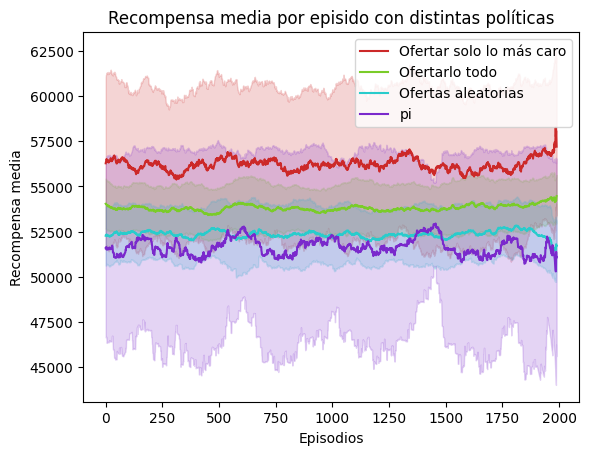

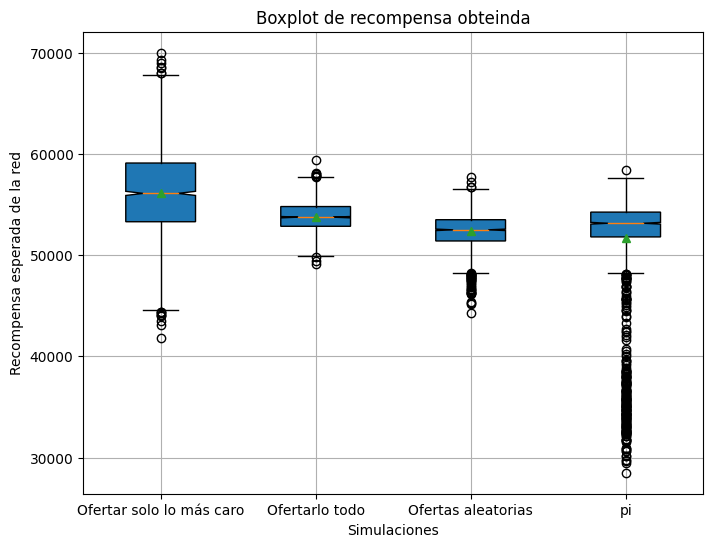

In [7]:
from algorithms.utils import generate_random_colors

colors = generate_random_colors(Num_politicas)
etiqueta =  ["Ofertar solo lo más caro", "Ofertarlo todo", "Ofertas aleatorias","pi"]

for p in range(Num_politicas):
    
    totals = Rs[p]
    x = np.array(totals).ravel()

    mean = np.array([np.mean(x[i:i+100]) for i in range(len(x) - 10)])
    std = np.array([np.std(x[i:i+100]) for i in range(len(x) - 10)])
    time = np.arange(mean.size)
    plt.plot(mean,color=colors[p],label = etiqueta[p])
    #plt.plot(Rsim, color = 'r')
    plt.fill_between(time, mean - std, mean + std, color=colors[p], alpha=0.2)
    plt.title("Recompensa media por episido con distintas políticas")
    plt.xlabel('Episodios')
    plt.ylabel('Recompensa media')
    plt.legend()
    

T_tf_mean = []
for i in range(Num_politicas):
    t_tf = []
    for x in S_sf[i]:
        t_tf.append(x[2])
    T_tf_mean.append(np.mean(t_tf))

print(T_tf_mean)

Rs_f_mean = []
for i in range(Num_politicas):
    Rs_f_mean.append(np.mean(Rs[i]))

print(Rs_f_mean)

datos = Rs
plt.figure(figsize=(8, 6))
plt.boxplot(datos, patch_artist=True, notch=True, showmeans=True)

plt.title('Boxplot de recompensa obteinda')
plt.xlabel('Simulaciones')
plt.ylabel('Recompensa esperada de la red')
plt.xticks(range(1,Num_politicas+1),etiqueta)  # Cambiar etiquetas del eje x
plt.grid(True)

plt.savefig("results/"+ name_exp +"/BoxPlot_" +Demand_Model + "_" + Qfun_model +"_" + Red_name +".png")

In [9]:
np.mean(Rs[0])

1761.05